## Importing Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer

import os
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is available


## Data Collection

In [ ]:
eyes = pd.read_csv('full_df.csv')
eyes.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


## Feature Selection and Scaling

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import string

stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = " ".join([stemmer.stem(word) for word in text.split()])
    return text

eyes['Right-Diagnostic Keywords'] = eyes['Right-Diagnostic Keywords'].apply(clean)

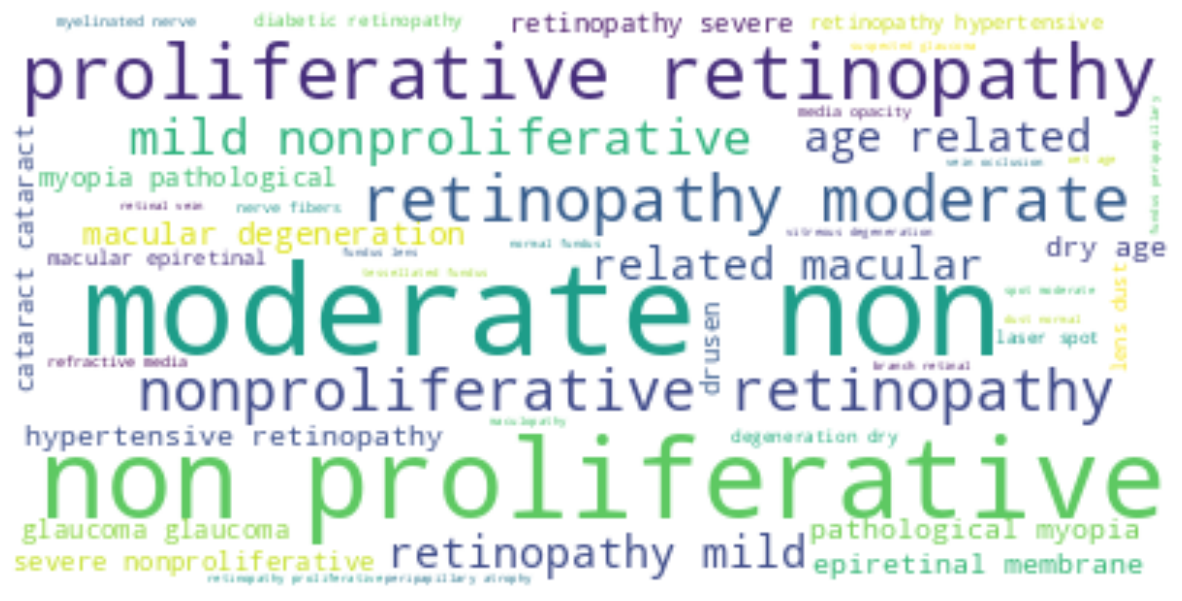

In [ ]:
text = " ".join(i for i in both_eyes_not_normal['Right-Diagnostic Keywords'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import zipfile
import os

zip_file_path = "preprocessed_images.zip"
extraction_dir = "preprocessed_images"

os.makedirs(extraction_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Extracted all files to :{extraction_dir}")

Extracted all files to :preprocessed_images


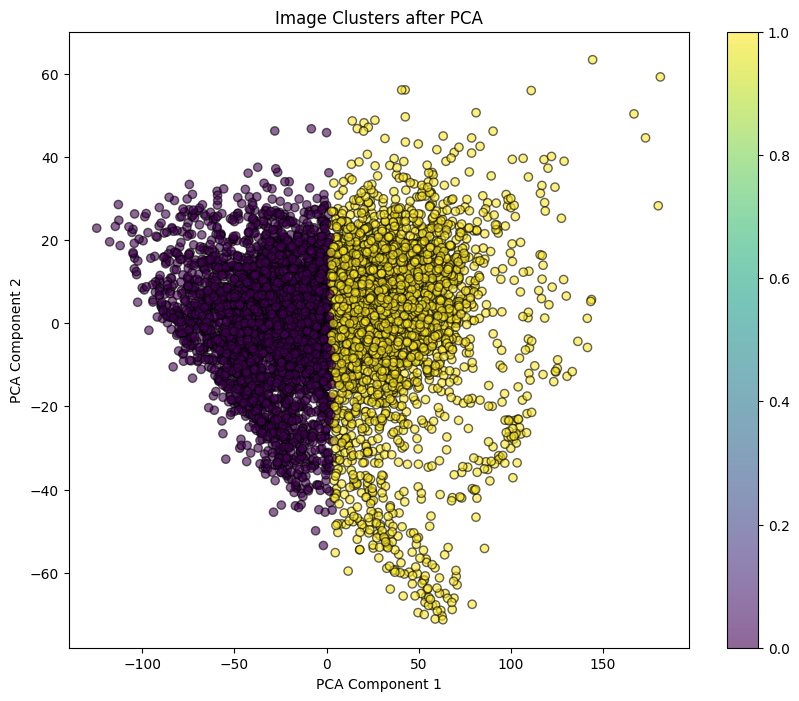

In [ ]:
train_dir = "/content/preprocessed_images"

file_paths = []
features = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('jpg', 'png', 'jpeg')):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

            image = cv2.imread(file_path)
            image = cv2.resize(image, (100, 100))
            avg_color = image.mean(axis=0).mean(axis=0)
            features.append(avg_color)

features = np.array(features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

eyes = pd.DataFrame({
    'file_path': file_paths,
    'PCA1': reduced_features[:, 0],
    'PCA2': reduced_features[:, 1],
    'cluster': clusters
})

plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title("Image Clusters after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

In [ ]:
eyes.head()

,file_path,PCA1,PCA2,cluster
0,/content/preprocessed_images/4427_left.jpg,-46.957329,-3.118465,0
1,/content/preprocessed_images/1092_left.jpg,-30.005362,-15.187568,0
2,/content/preprocessed_images/1561_left.jpg,57.782887,-4.862305,1
3,/content/preprocessed_images/4467_right.jpg,57.201571,-5.413068,1
4,/content/preprocessed_images/3107_right.jpg,-41.709976,7.806186,0


In [ ]:
eyes['cluster'].value_counts()

,count
cluster,
0,3436
1,2956


In [ ]:
eyes.drop(columns = ['PCA1' , 'PCA2'], axis=1 , inplace = True)

In [ ]:
eyes.head()

,file_path,cluster
0,/content/preprocessed_images/4427_left.jpg,0
1,/content/preprocessed_images/1092_left.jpg,0
2,/content/preprocessed_images/1561_left.jpg,1
3,/content/preprocessed_images/4467_right.jpg,1
4,/content/preprocessed_images/3107_right.jpg,0


In [ ]:
eyes['cluster'].value_counts()

,count
cluster,
0,3436
1,2956


In [ ]:
eyes['cluster'] = eyes['cluster'].replace({0: 'X', 1: 'N'})

In [ ]:
train_data, test = train_test_split(eyes, test_size=0.4, random_state=42, stratify=eyes['cluster'])
test, valid_data = train_test_split(test, test_size=0.5, random_state=42, stratify=test['cluster'])

print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (3835, 2)
Validation set shape: (1279, 2)
Testing set shape: (1278, 2)


## Training Data Preperation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255 )

# Create an ImageDataGenerator for validation and test data (no data augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the input size expected by the model
input_size = (224, 224)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle = True,
    batch_size=12,
    class_mode='categorical',
    color_mode = 'rgb'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle = True,
    batch_size=12,
    class_mode='categorical',
    color_mode = 'rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle=False,
    batch_size=12,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 3835 validated image filenames belonging to 2 classes.
Found 1279 validated image filenames belonging to 2 classes.
Found 1278 validated image filenames belonging to 2 classes.


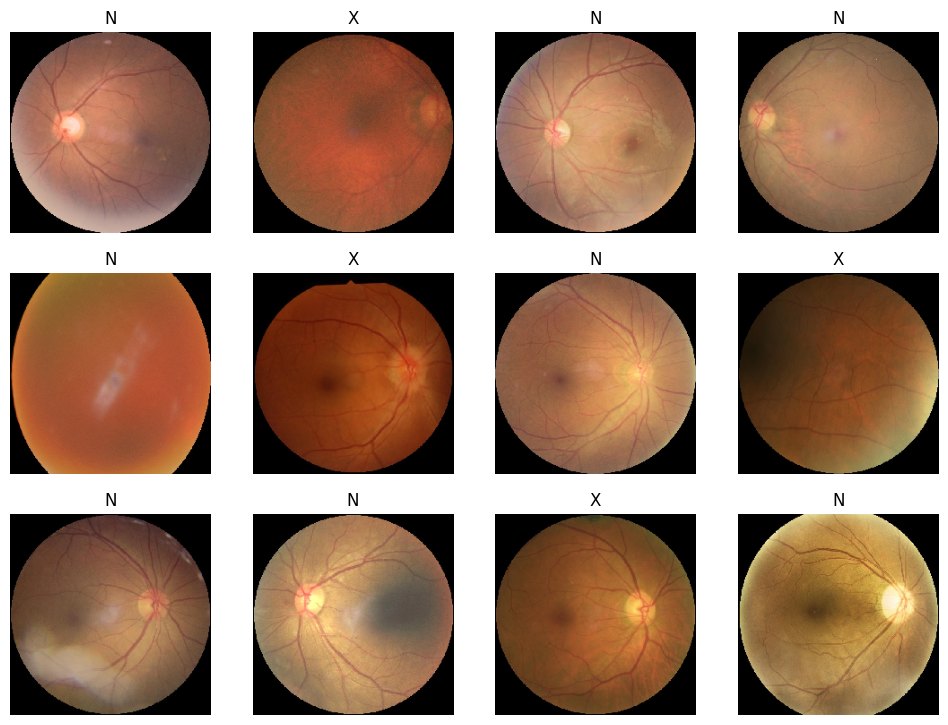

In [ ]:
sample_images, sample_labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(12):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i])
    label = list(train_generator.class_indices.keys())[label_index]

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()

## Model Building

In [ ]:
input_shape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(256, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,365,538 (12.84 MB)

 Trainable params: 3,365,538 (12.84 MB)

 Non-trainable params: 0 (0.00 B)

## Model Callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('brain_tumors/best_model.keras', save_best_only=True)

## Model Fitting

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=valid_generator,
                    validation_steps = None , shuffle = False,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 305s 833ms/step - accuracy: 0.7455 - loss: 1.3389 - val_accuracy: 0.9062 - val_loss: 0.2605
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 241s 687ms/step - accuracy: 0.9442 - loss: 0.1912 - val_accuracy: 0.9593 - val_loss: 0.1581
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 220s 687ms/step - accuracy: 0.9306 - loss: 0.1797 - val_accuracy: 0.8741 - val_loss: 0.3278
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 219s 685ms/step - accuracy: 0.9531 - loss: 0.1409 - val_accuracy: 0.9421 - val_loss: 0.1440
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 219s 684ms/step - accuracy: 0.9376 - loss: 0.1735 - val_accuracy: 0.9586 - val_loss: 0.1174
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 219s 683ms/step - accuracy: 0.9595 - loss: 0.1188 - val_accuracy: 0.9711 - val_loss: 0.0977
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 218s 681ms/step - accuracy: 0.9541 - loss: 0.1251 - val_accuracy: 0.9672 - val_loss: 0.1010
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 217s 680ms/step - accuracy: 0.9503 -

## Plotting Accuracy and Loss Curves

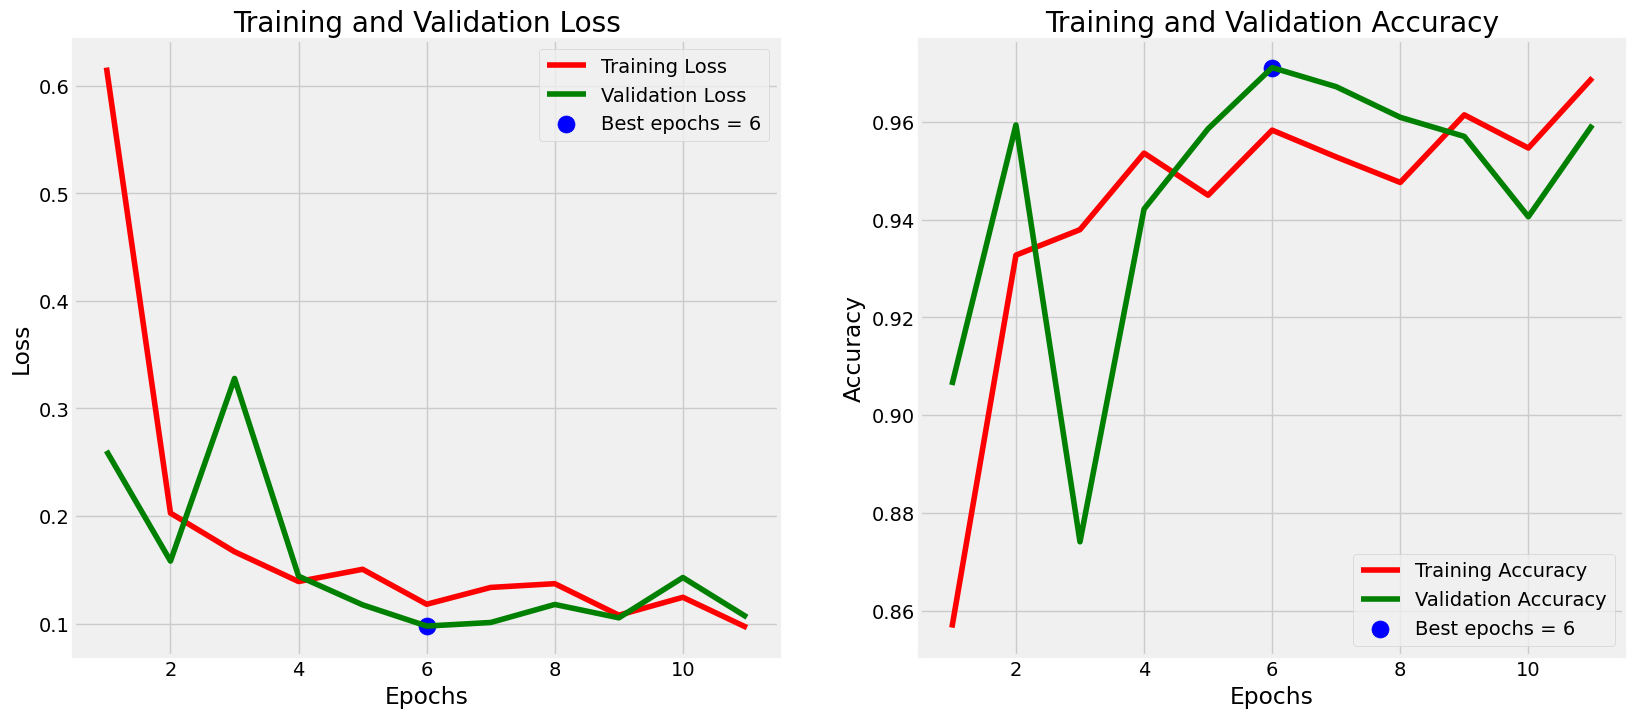

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

## Model Evaluation

In [ ]:
# Evaluate the model on the training set
train_score = model.evaluate(train_generator)
print(f"Training Loss: {train_score[0]}, Training Accuracy: {train_score[1]}")

# Evaluate the model on the validation set
valid_score = model.evaluate(valid_generator)
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")

# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

320/320 ━━━━━━━━━━━━━━━━━━━━ 61s 189ms/step - accuracy: 0.9812 - loss: 0.0793
Training Loss: 0.07621616125106812, Training Accuracy: 0.9835723638534546
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.9767 - loss: 0.0913
Validation Loss: 0.09768357127904892, Validation Accuracy: 0.9710711240768433
107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 260ms/step - accuracy: 0.9822 - loss: 0.0841
Test Loss: 0.09298631548881531, Test Accuracy: 0.9773082733154297


## Model Prediction

In [ ]:
preds = model.predict(test_generator)

y_pred = np.argmax(preds, axis=1)

107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step


## Confusion Matrix

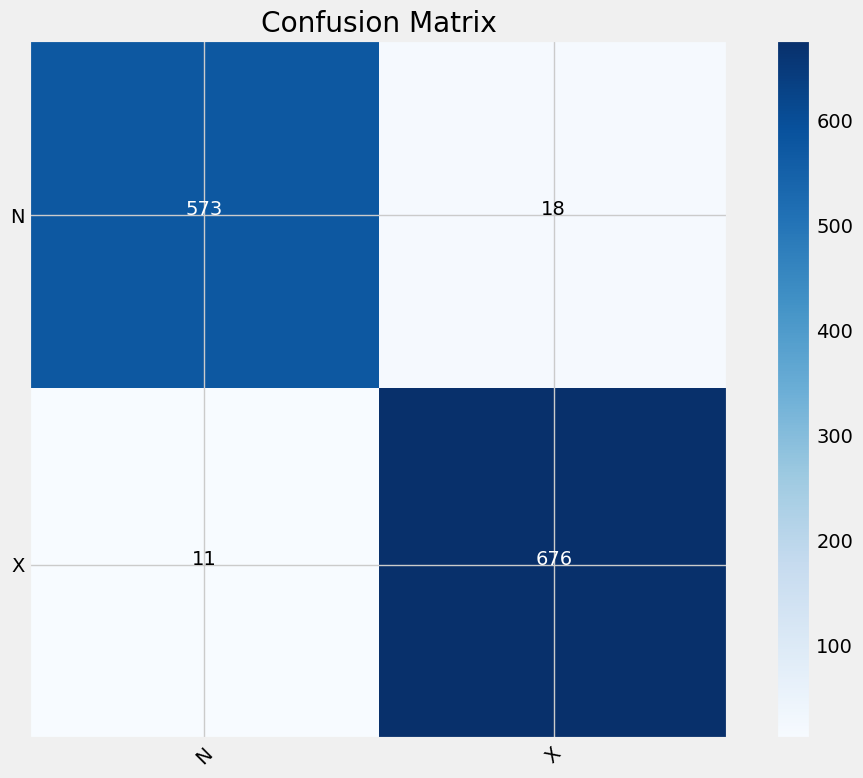

In [ ]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()

plt.show()

## Classification Report

In [ ]:
print(classification_report(test_generator.classes, y_pred , target_names= classes))

              precision    recall  f1-score   support

           N       0.98      0.97      0.98       591
           X       0.97      0.98      0.98       687

    accuracy                           0.98      1278
   macro avg       0.98      0.98      0.98      1278
weighted avg       0.98      0.98      0.98      1278

